# 1000 Genomes Exercises in SciDB

SciDB is a scale-out DBMS designed for scientific use cases, with built-in capabilities for sophisticated mathematical calculations beyond the typical domain of SQL/NoSQL systems. This workbook demonstrates using SciDB's R interface for scalable query and analysis of 1000 Genomes phase 3 genotype data, including simple aggregations such as computing transition/transversion ratios, and more advanced calculations such as principal component analysis and estimating linkage disequilibrium.

First, we connect to SciDB and obtain handles to the data arrays. For development/testing on a modest machine, we'll just look at chromosomes 21 and 22 across the 2,504 individuals; but SciDB can scale out on a cluster to handle arbitrarily large datasets.

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from scidbpy import connect
import time
from skimage import data, io, filters

sdb = connect()
SAMPLE = sdb.wrap_array('KG_SAMPLE')
CHROMOSOME = sdb.wrap_array('KG_CHROMOSOME')
VARIANT = sdb.merge(sdb.wrap_array('KG_VARIANT'), 
                    sdb.afl.filter("KG_CHROMOSOME", "chromosome='10' or chromosome='20' or chromosome='21'"))
VARIANT.eval()
GENOTYPE = sdb.afl.project(
    sdb.merge(
        sdb.wrap_array('KG_GENOTYPE'),
        sdb.afl.project(VARIANT, 'chromosome')
        ),
    'allele_1', 'allele_2', 'phase'
    )

The `VARIANT` array for chomosomes 21 and 22 has been stored in SciDB's memory (but not the memory of our local R process) by the `scidbeval()` expression above. In contrast, the `GENOTYPE` array is merely a lazy expression, denoting but not materializing the subset of all the genotypes on chromosomes 21 and 22. Because `GENOTYPE` is our biggest array by far, we avoid copying any significant portion of it.

Let's take a look at the schema.

In [2]:
VARIANT.todataframe().head()

reference alternate           id  qual  \
chromosome_id start end   alternate_id                                          
9             60494 60494 1                    A         G            .   100   
              60515 60515 1                    C         T            .   100   
              60523 60523 1                    T         G  rs148087467   100   
              60607 60607 1                    G         A            .   100   
              60684 60684 1                    A         C            .   100   

                                       filter  \
chromosome_id start end   alternate_id          
9             60494 60494 1              PASS   
              60515 60515 1              PASS   
              60523 60523 1              PASS   
              60607 60607 1              PASS   
              60684 60684 1              PASS   

                                                                       info  \
chromosome_id start end   alternate_id                                        
9             60494 60494 1             AC=27;AF=0.00539137;AN=5008;NS=2504   
              60515 60515 1             AC=1;AF=0.000199681;AN=5008;NS=2504   
              60523 60523 1              AC=91;AF=0.0181709;AN=5008;NS=2504   
              60607 60607 1             AC=1;AF=0.000199681;AN=5008;NS=2504   
              60684 60684 1              AC=62;AF=0.0123802;AN=5008;NS=2504   

                                        ac        af chromosome  
chromosome_id start end   alternate_id                           
9             60494 60494 1             27  0.005391         10  
              60515 60515 1              1  0.000200         10  
              60523 60523 1             91  0.018171         10  
              60607 60607 1              1  0.000200         10  
              60684 60684 1             62  0.012380         10  

[5 rows x 9 columns]

In [3]:
VARIANT.schema

u'<reference:string,alternate:string,id:string NULL DEFAULT null,qual:double NULL DEFAULT null,filter:string NULL DEFAULT null,info:string NULL DEFAULT null,ac:double NULL DEFAULT null,af:double NULL DEFAULT null,chromosome:string> [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0]'

In [4]:
VARIANT.count().toarray()[0][0]

19864.0

In [5]:
GENOTYPE[9,60494,60494,1,0:5].todataframe()

,allele_1,allele_2,phase
sample_id,,,
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [6]:
GENOTYPE.schema

u'<allele_1:bool NULL DEFAULT null,allele_2:bool NULL DEFAULT null,phase:bool NULL DEFAULT null> [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0,sample_id=0:*,100,0]'

In [7]:
int(GENOTYPE.op_count().toarray()[0])

49739456

On the other hand, small arrays can easily be moved back and forth between SciDB and R, with one pitfall: SciDB arrays are zero-based, while R uses one-based indexing. But as genome scientists, we're right at home dealing with that!

## Transition/transversion ratio

The transition/transversion ratio (Ti/Tv) is a common quality metric for variant call sets. Let's compute Ti/Tv of all the variants with respect to the reference genome. This first calculation is on the variants only, not the individuals' genotypes, and thus involves only a modest amount of data.


In [8]:
SNP = sdb.afl.filter(VARIANT, "(reference='A' or reference='G' or reference='C' or reference='T') and \
                        (alternate='A' or alternate='G' or alternate='C' or alternate='T')")
snps = int(SNP.op_count().toarray()[0])
snps

18840

In [9]:
# annotate each SNP as to whether it's a transition (or else transversion)

transitions_filter_str =   "(reference='A' and alternate='G') or (reference='G' and alternate='A') or \
                            (reference='C' and alternate='T') or (reference='T' and alternate='C')"
SNP = sdb.afl.apply(SNP, "is_transition", "bool(iif(%s, 1, 0))" % transitions_filter_str)
SNP = SNP.eval()

# count transitions
ti = int((sdb.afl.filter(SNP['is_transition'], "is_transition = TRUE").count()).toarray()[0])
ti

13209

In [10]:
# count transversions
tv = int((sdb.afl.filter(SNP['is_transition'], "is_transition = FALSE").count()).toarray()[0])
tv

5631

In [11]:
# report Ti/Tv
assert ti + tv == snps
float(ti)/tv

2.345764517847629

Now let's look at the distribution of Ti/Tv across the individuals in the population. The R notebook uses pipeR's `%>>%` operator to express a multi-step data processing pipeline, where `f(x) %>>% g(y)` denotes `g(f(x),y)`.

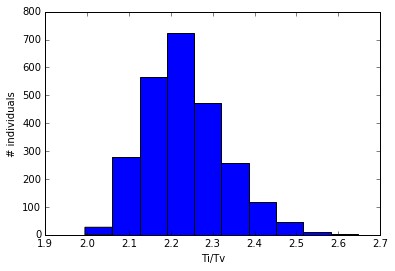

In [13]:
def calculate_titv(G):
    expr = G.apply("alt_copies", "iif(allele_1,1,0)+ iif(allele_2,1,0)")
    expr = sdb.merge(expr, SNP['is_transition'])
    expr = expr.apply("ti", "iif(is_transition, alt_copies, 0)", \
                          "tv", "iif(not is_transition, alt_copies, 0)").\
            aggregate("sum(ti) as ti, sum(tv) as tv", "sample_id").\
            eval()
    return expr

titv = calculate_titv(GENOTYPE).todataframe()

plt.hist(titv['ti']/titv['tv'])
plt.title("")
plt.xlabel("Ti/Tv")
plt.ylabel("# individuals")
plt.show()

All the data traversal is performed by SciDB in parallel; then the histogram buckets and counts are imported into R memory for plotting. Note that lazily-evaluated subexpressions can be stored, composed, and reused as R variables. This is often a lot nicer than formulating SQL!

We can also calculate Ti/Tv for just one individual, by filtering the input matrix:

In [14]:
titv1 = calculate_titv(
    sdb.merge(
        GENOTYPE, 
        sdb.afl.filter(SAMPLE['sample'], "sample = 'HG03209'")
    )
    ).todataframe()
titv1['ti']/titv1['tv']

sample_id
1234         2.275641
dtype: float64

## Principal component analysis

Now let's find principal components of the genotype data and project the individual genomes onto them, revealing the underlying population structure. Begin by selecting common SNPs, because rare variants inherently don't contribute much to the overall variance.

Select all variants whose af is greater than min_af and less than max_af; if variant_limit is
specified, then select up to that many variants, chosen randomly. 

In [2]:
min_af = 0.1
max_af = 0.9
chunk_size=512
#variant_limit = 4

t0 = time.clock()
KG_CHROMOSOME = sdb.wrap_array("KG_CHROMOSOME")
KG_VARIANT    = sdb.wrap_array("KG_VARIANT")
KG_GENOTYPE   = sdb.wrap_array("KG_GENOTYPE")
KG_SAMPLE     = sdb.wrap_array("KG_SAMPLE")

KG_POPULATION = sdb.wrap_array("KG_POPULATION")
#selected_variants = dimension_rename(project(unpack(subset(KG_VARIANT, sprintf("af>%f and af<%f", 
#  min_af, max_af))), c("chromosome_id, start, end, alternate_id")), old="i", new="dense_variant_id")
selected_variants = KG_VARIANT.filter("af>%f and af<%f" % (min_af, max_af))\
                                .unpack()\
                                .project("chromosome_id, start, end, alternate_id")\
                                .dimension_rename('idx', 'dense_variant_id')

if 'variant_limit' in locals() or 'variant_limit' in globals():
    selected_variants = selected_variants.apply("randomizer", "random()")\
                                            .sort("randomizer asc")\
                                            .between(0, variant_limit-1)\
                                            .dimension_rename('n', 'dense_variant_id')
    
selected_variants = selected_variants.eval()
num_variants = int(selected_variants.op_count().toarray()[0])
num_samples = int(KG_SAMPLE.op_count().toarray()[0])
print("%f %f: Found %i variants that fit the criteria; running [%i x %i]" %
              ((time.clock()-t0), (time.clock()-t0), num_variants, num_variants, num_samples))


0.074606 0.074608: Found 1028 variants that fit the criteria; running [1028 x 2504]


The redimension operation just removes some unneeded attributes and dimensions.

In [3]:
t1=time.clock()
redim_guide = selected_variants.redimension("<dense_variant_id:int64> \
        [chromosome_id=0:*,1,0,start=0:*,10000000,0,end=0:*,10000000,0,alternate_id=0:19,20,0]")
#        scidb:::build_dim_schema(KG_VARIANT)))

<value> [sample_id, variant_number] where value is 2 if the variant is present in both alleles,
1 if the variant is present in one allele or 0 otherwise. 

In [4]:
redim_matrix = KG_GENOTYPE.apply("v", "double(iif(allele_1 and allele_2, 2.0, iif(allele_1 or allele_2, 1.0, 0.0)))")
redim_matrix = sdb.merge(redim_matrix, redim_guide)
redim_matrix = redim_matrix.redimension("<v:double null> [sample_id = 0:%i,%i,0, dense_variant_id=0:%i,%i,0]" % 
                                                 (num_samples-1, chunk_size, num_variants-1, chunk_size))\
                            .substitute("double(nan)")\
                            .eval()
print("%f %f: Built matrix" % ((time.clock()-t0), (time.clock()-t1)))

0.130892 0.051398: Built matrix


Sweep out the column means

In [5]:
t1=time.clock()
centered = redim_matrix - redim_matrix.mean(0)
centered = centered.eval()
print("%f %f: Centered" % ((time.clock()-t0), (time.clock()-t1)))

0.169093 0.032855: Centered


## Calculate covariance


Calculate and display the covariance
{Previous text}: Normalize each variable and compute the sample covariance matrix ("economy-sized", since we have many more variables than observations):

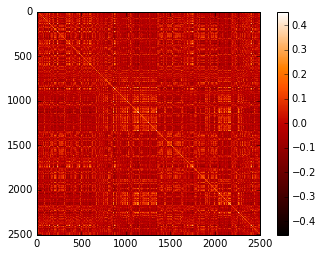

In [19]:
X = centered
Y = X.T  # samples in columns
Y = Y - Y.mean(0)
CV = (sdb.dot(X, Y)/(X.shape[0]-1)).toarray()
io.imshow(CV, cmap='gist_heat')
io.show()

Both axes above are simply the 2,504 samples in the phase 3 data. The observed correlation structure probably just reflects how the 1000 Genomes project added sample batches of various ethnicities over time.

Now perform SVD on the covariance matrix

In [21]:
t1=time.clock()
svded = sdb.afl.gesvd("%s, 'left'" % centered.name)\
            .eval()
print("%f %f: SVD Computed" % ((time.clock()-t0), (time.clock()-t1)))
download = svded[:, 0:3].toarray()

2.139606 0.004046: SVD Computed


Next plot the projection of the observations (individuals) onto the first three principal components:

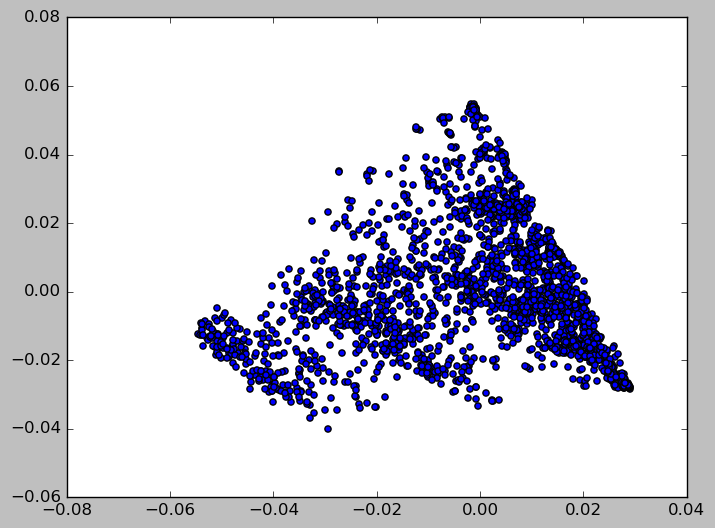

In [22]:
plt.scatter(download[:,0], download[:,1])
plt.show()


For the avoidance of doubt: all the matrix calculations here were parallelized in SciDB, not computed by the local R process. We didn't have to dump a lot of data into any separate system for numerical analysis.

{Previous text}: Now construct a matrix `G` where `G[i,j]` is the number of copies of the alt allele found in sample `i`, common SNP `j`. The samples are observations, and the SNPs are variables. Reference: doi:10.1371/journal.pgen.0020190

The PCA's interpretation becomes clear if we label the points by the ethnicity of each individual. This also provides an elementary example of joining "phenotypic data":

Make a cute 3D plot (to be added)

### To be done